In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [4]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [5]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [6]:
data = read_text("./Dataset/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng = deu_eng[:50000,:]

In [8]:
deu_eng[:10]

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run!', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ['Run.', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
       ['Wow!', 'Potzdonner!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)'],
       ['Wow!', 'Donnerwetter!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
       ['Duck!', 'Kopf runter!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #9968521 (wolfgangth)'],
       

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom has no free time', 'Tom hat keine Freizeit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5007466 (CK) & #10095033 (wolfgangth)'],
       ['Tom has no neighbors', 'Tom hat keine Nachbarn',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5148452 (CK) & #7453873 (Pfirsichbaeumchen)'],
       ['Tom has nothing left', 'Tom hat nichts mehr übrig',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4500591 (CK) & #10095020 (wolfgangth)']],
      dtype='<U537')

In [11]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['tom has no free time', 'tom hat keine freizeit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5007466 (CK) & #10095033 (wolfgangth)'],
       ['tom has no neighbors', 'tom hat keine nachbarn',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5148452 (CK) & #7453873 (Pfirsichbaeumchen)'],
       ['tom has nothing left', 'tom hat nichts mehr übrig',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4500591 (CK) & #10095020 (wolfgangth)']],
      dtype='<U537')

array([[<AxesSubplot:title={'center':'eng'}>,
        <AxesSubplot:title={'center':'deu'}>]], dtype=object)

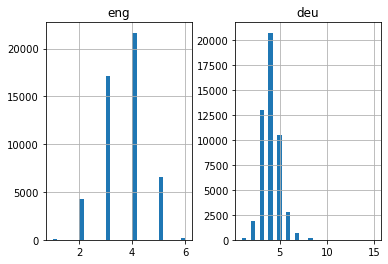

In [13]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)


In [14]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6106


In [16]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10060


In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [18]:
deu_eng.tolist()

[['go',
  'geh',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
 ['hi',
  'hallo',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
 ['hi',
  'grüß gott',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
 ['run',
  'lauf',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
 ['run',
  'lauf',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
 ['wow',
  'potzdonner',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)'],
 ['wow',
  'donnerwetter',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
 ['duck',
  'kopf runter',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #9968521 (wolfgangth)'],
 ['fire',
  'feuer',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #1958697 (Tam

In [19]:
deu_eng = deu_eng[:,:2]

In [20]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['tom has no free time', 'tom hat keine freizeit'],
       ['tom has no neighbors', 'tom hat keine nachbarn'],
       ['tom has nothing left', 'tom hat nichts mehr übrig']],
      dtype='<U537')

In [21]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [22]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [23]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [24]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [25]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [32]:
filename = 'model.h1.13.07.2022'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.3351
Epoch 1: val_loss improved from inf to 2.79209, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 64s 800ms/step - loss: 3.3351 - val_loss: 2.7921
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.6922
Epoch 2: val_loss improved from 2.79209 to 2.64173, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 63s 1s/step - loss: 2.6922 - val_loss: 2.6417
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.4981
Epoch 3: val_loss improved from 2.64173 to 2.49817, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 67s 1s/step - loss: 2.4981 - val_loss: 2.4982
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.3223
Epoch 4: val_loss improved from 2.49817 to 2.33093, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 106s 2s/step - loss: 2.3223 - val_loss: 2.3309
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.1747
Epoch 5: val_loss improved from 2.33093 to 2.21855, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 118s 2s/step - loss: 2.1747 - val_loss: 2.2186
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.0362
Epoch 6: val_loss improved from 2.21855 to 2.10083, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 130s 2s/step - loss: 2.0362 - val_loss: 2.1008
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 1.9125
Epoch 7: val_loss improved from 2.10083 to 2.02151, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 143s 2s/step - loss: 1.9125 - val_loss: 2.0215
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.7961
Epoch 8: val_loss improved from 2.02151 to 1.91852, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 131s 2s/step - loss: 1.7961 - val_loss: 1.9185
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.6891
Epoch 9: val_loss improved from 1.91852 to 1.86930, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 145s 2s/step - loss: 1.6891 - val_loss: 1.8693
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.5890
Epoch 10: val_loss improved from 1.86930 to 1.78019, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 157s 3s/step - loss: 1.5890 - val_loss: 1.7802
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.4909
Epoch 11: val_loss improved from 1.78019 to 1.72281, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 137s 2s/step - loss: 1.4909 - val_loss: 1.7228
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.4000
Epoch 12: val_loss improved from 1.72281 to 1.66047, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 49s 784ms/step - loss: 1.4000 - val_loss: 1.6605
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.3125
Epoch 13: val_loss improved from 1.66047 to 1.61023, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 45s 723ms/step - loss: 1.3125 - val_loss: 1.6102
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.2273
Epoch 14: val_loss improved from 1.61023 to 1.55818, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 34s 544ms/step - loss: 1.2273 - val_loss: 1.5582
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.1482
Epoch 15: val_loss improved from 1.55818 to 1.52252, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 33s 525ms/step - loss: 1.1482 - val_loss: 1.5225
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.0744
Epoch 16: val_loss improved from 1.52252 to 1.48926, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 32s 515ms/step - loss: 1.0744 - val_loss: 1.4893
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.0013
Epoch 17: val_loss improved from 1.48926 to 1.45739, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 33s 533ms/step - loss: 1.0013 - val_loss: 1.4574
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.9322
Epoch 18: val_loss improved from 1.45739 to 1.41804, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 32s 505ms/step - loss: 0.9322 - val_loss: 1.4180
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.8673
Epoch 19: val_loss improved from 1.41804 to 1.38680, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 26s 411ms/step - loss: 0.8673 - val_loss: 1.3868
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.8051
Epoch 20: val_loss improved from 1.38680 to 1.36797, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 26s 408ms/step - loss: 0.8051 - val_loss: 1.3680
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.7442
Epoch 21: val_loss improved from 1.36797 to 1.33850, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 26s 420ms/step - loss: 0.7442 - val_loss: 1.3385
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.6910
Epoch 22: val_loss improved from 1.33850 to 1.32690, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 25s 401ms/step - loss: 0.6910 - val_loss: 1.3269
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.6388
Epoch 23: val_loss improved from 1.32690 to 1.29890, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 26s 417ms/step - loss: 0.6388 - val_loss: 1.2989
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.5879
Epoch 24: val_loss improved from 1.29890 to 1.28665, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 25s 401ms/step - loss: 0.5879 - val_loss: 1.2867
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.5422
Epoch 25: val_loss improved from 1.28665 to 1.27311, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 25s 407ms/step - loss: 0.5422 - val_loss: 1.2731
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.4976
Epoch 26: val_loss improved from 1.27311 to 1.26253, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 26s 419ms/step - loss: 0.4976 - val_loss: 1.2625
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.4585
Epoch 27: val_loss improved from 1.26253 to 1.25492, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 27s 429ms/step - loss: 0.4585 - val_loss: 1.2549
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.4184
Epoch 28: val_loss improved from 1.25492 to 1.25289, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 28s 449ms/step - loss: 0.4184 - val_loss: 1.2529
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.3824
Epoch 29: val_loss improved from 1.25289 to 1.24193, saving model to model.h1.13.07.2022


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


INFO:tensorflow:Assets written to: model.h1.13.07.2022\assets


63/63 [==============================] - 29s 464ms/step - loss: 0.3824 - val_loss: 1.2419
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.3501
Epoch 30: val_loss did not improve from 1.24193
63/63 [==============================] - 10s 159ms/step - loss: 0.3501 - val_loss: 1.2444


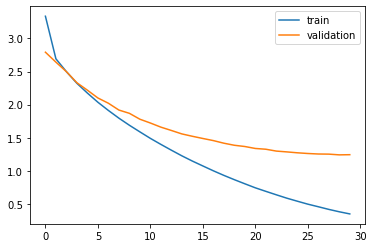

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.savefig('loss_comparison.png')